In [42]:
import sys, cv2
import numpy as np
import tracktor_revised as tr
import matplotlib.pyplot as plt
import pickle
import os
import collections

In [ ]:
# Open video file.
video_file        = '../Data/SF_n2_t2_3113.mp4'
cap               = cv2.VideoCapture(video_file)
n_frames          = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps               = cap.get(cv2.CAP_PROP_FPS)
print(f'{n_frames} frames, {fps} frames per second.')

# Contour detection parameters.
block_size,offset = 15,13
min_area,max_area = 20,1000
n_pix             = 5

# 1. Creating dataset from file

## 1.1 Manually creates the fish data set from the video file. This cell is currently disabled. 

In [ ]:
# List of frames to analyze.
#frameID_list = range(5000,50000,50)
frameID_list = range(5000,n_frames,1)

# Data structure to hold only the pixels belonging to a fish and their brightness.
fish = []

#Uncomment line to make this cell run, commented to force notebook to use the .pkl file for speed. (This cell takes over an hour.)
#for i in frameID_list:
    
    # Load the frame.
    cap.set(cv2.CAP_PROP_POS_FRAMES, i-1)
    ret,frame = cap.read()
    
    # Detect the contours.
    contours  = tr.contour_detect(frame,min_area,max_area,block_size,offset,n_pix)
    
    # Make a mask with value j inside fish number j and -1 elsewhere. 
    mask      = 0*cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) - 1
    for j in range(len(contours)):
        cv2.drawContours(mask, contours, j, j, -1)
    
    # Make and save a list of each fish's pixels.
    pixels=[]
    subFish=[]
    for j in range(len(contours)):
        pixels=(np.nonzero(mask==j))
        n =len(pixels[0]) # Number of pixels in J
        subSubFish=[]
        for k in range(n):
            row=pixels[0][k]
            col=pixels[1][k]
            rgb=frame[row,col]
            grey=round(.3*rgb[0]+.59*rgb[1]+.11*rgb[2],2)
            subSubFish.append([row,col,grey]) #Pixel
        subFish.append(np.array(subSubFish)) #Fish
    fish.append(subFish) #Frame

with open('fish.pkl','wb') as fh:
     pickle.dump(fish,fh)

## 1.2 Reads fish.pkl to create fish.

In [2]:
with open('fish.pkl','rb') as fh:
     fish=pickle.load(fh)

# 2. Fish Overlap Check

## 2.1 Checks fish for sections where the program is reading the fish as one object due to proximity, and returns a list of where the fish are not overlapping.

In [3]:
i2=0
nonOverlappingRange=[]
while i2<len(fish):
    i1=i2
    while i1<len(fish) and len(fish[i1])!=2:
        i1+=1
    i2=i1
    while i2 < len(fish) and len(fish[i2])==2:
        #find the first overlapping index
        i2+=1
    nonOverlappingRange.append([i1,i2])
print(nonOverlappingRange)

[[0, 137], [138, 204], [207, 247], [248, 371], [379, 624], [625, 916], [918, 1164], [1168, 1203], [1205, 1345], [1351, 1380], [1382, 1804], [1815, 1825], [1826, 2707], [2710, 2785], [2792, 3048], [3061, 3229], [3230, 3233], [3236, 3290], [3295, 3595], [3597, 3598], [3602, 3658], [3661, 3733], [3738, 3770], [3774, 3781], [3788, 3896], [3898, 3918], [3920, 4062], [4068, 4155], [4157, 4389], [4390, 4551], [4552, 4589], [4591, 5152], [5155, 6433], [6434, 6436], [6437, 8500], [8501, 8536], [8549, 8945], [8948, 9123], [9141, 9508], [9539, 9571], [9697, 9947], [9952, 10030], [10040, 10095], [10112, 10208], [10216, 11231], [11235, 11646], [11648, 11653], [11654, 12363], [12364, 12427], [12430, 12567], [12574, 12995], [13006, 13076], [13081, 13913], [13914, 14436], [14439, 14536], [14543, 14580], [14581, 14583], [14584, 14681], [14692, 15300], [15304, 15466], [15470, 15600], [15603, 15826], [15829, 16667], [16671, 17110], [17117, 17463], [17465, 17657], [17660, 17768], [17783, 17947], [17955, 1

## 2.2 Checks to see that the nonOverlappingRange was created correctly.

In [4]:
for i in range(1,len(nonOverlappingRange)-1):
    if nonOverlappingRange[i][:-1] and not nonOverlappingRange[i][1:]:
        print(i)

## 2.3 Finds the longest consuctive streach where the fish are not overlapping.

In [5]:
crossedList=[]
for i in range(len(nonOverlappingRange)):
    crossedList.append(nonOverlappingRange[i][1]-nonOverlappingRange[1][0])
print(crossedList)

[-1, 66, 109, 233, 486, 778, 1026, 1065, 1207, 1242, 1666, 1687, 2569, 2647, 2910, 3091, 3095, 3152, 3457, 3460, 3520, 3595, 3632, 3643, 3758, 3780, 3924, 4017, 4251, 4413, 4451, 5014, 6295, 6298, 8362, 8398, 8807, 8985, 9370, 9433, 9809, 9892, 9957, 10070, 11093, 11508, 11515, 12225, 12289, 12429, 12857, 12938, 13775, 14298, 14398, 14442, 14445, 14543, 15162, 15328, 15462, 15688, 16529, 16972, 17325, 17519, 17630, 17809, 17818, 17992, 18027, 18665, 18679, 19901, 20851, 21246, 21262, 21565, 21570, 21623, 21697, 22002, 22072, 22074, 22076, 22086, 22137, 22377, 22387, 22733, 23481, 23533, 23960, 26451, 27152, 27658, 27746, 27949, 27981, 28056, 28183, 28955, 29196, 29347, 29554, 29565, 29751, 29755, 29844, 30134, 30180, 30273, 30366, 31012, 31305, 31639, 31649, 31702, 31959, 32123, 32287, 32613, 32718, 33020, 34832, 34834, 34878, 34913, 35638, 35680, 35684, 35712, 35826, 35898, 36104, 36108, 36258, 36598, 36601, 37578, 37908, 37940, 38127, 38163, 38167, 38351, 38415, 38468, 39096, 39133, 

In [10]:
#Take a list of each strech where the fish don't cross so that we can check which fish is which after they cross by comparing it to either the first or the longest streach uncrossed
#See 1 on fily's paper
longestDistance=[]
distance=0
for i in range(len(nonOverlappingRange)):
    if (nonOverlappingRange[i][-1]-nonOverlappingRange[i][0])>distance:
        distance=(nonOverlappingRange[i][-1]-nonOverlappingRange[i][0])
        longestDistance=[distance,i,nonOverlappingRange[i][-1],nonOverlappingRange[i][0]]
print(longestDistance)

[2481, 93, 26589, 24108]


## 2.4 Finds the center of each fish.

In [15]:
#finding the center of each fish
#2 on fily's paper
fishMean=[]
for i in range(len(fish)):
    if len(fish[i])==1:
        fishMean.append([[np.mean(fish[i][0].T[0]),np.mean(fish[i][0].T[1])],[np.mean(fish[i][0].T[0]),np.mean(fish[i][0].T[1])]])
    else:
        fishMean.append([[np.mean(fish[i][0].T[0]),np.mean(fish[i][0].T[1])],[np.mean(fish[i][1].T[0]),np.mean(fish[i][1].T[1])]])
fishMean=np.asarray(fishMean)
#fishMean[i.j.k] is the coordianate of k of the position of fjsh j in frame i

## 2.5 Plots the paths of the two fish using their centers.

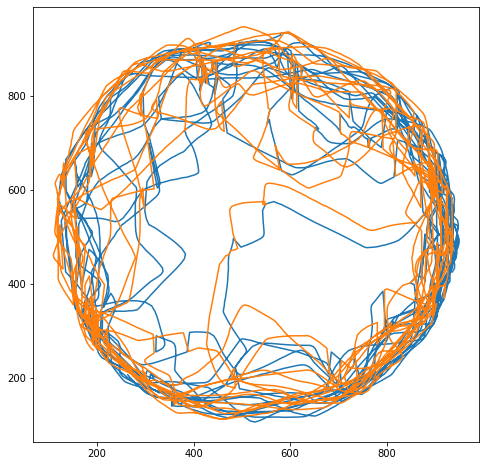

In [7]:
plt.figure(figsize=(8,8))
I = slice(0,5000)
plt.plot(fishMean[I,0,0],fishMean[I,0,1])
plt.plot(fishMean[I,1,0],fishMean[I,1,1])
plt.show()

## 2.6 Measures the distance between each fish during each nonoverlapping section to vertifiy that they are the same fish.

In [30]:
# Create array of distances between two fishes to find switching using [[i,0-i+1,0][i,1-i+1,1][i,0-i+1,1][i,1-i+1,0]]

def normFunc(i,j):
    nOR=nonOverlappingRange[i][j]
    nOR1=nonOverlappingRange[i+1][j]
    return [[np.linalg.norm(fishMean[nOR1][0]-fishMean[nOR][0])],
           [np.linalg.norm(fishMean[nOR1][1]-fishMean[nOR][1])],
           [np.linalg.norm(fishMean[nOR1][0]-fishMean[nOR][1])],
           [np.linalg.norm(fishMean[nOR1][1]-fishMean[nOR][0])]]

fishQuadDistance=[]
for i in range(len(nonOverlappingRange)-1):
    for j in range(len(nonOverlappingRange[i])-1):
        #print(i,j)
        fishQuadDistance.append(np.array(normFunc(i,j)))
fishQuadDistance=np.array(fishQuadDistance)

In [32]:
def normFunc(i):
    return [[np.linalg.norm(fishMean[i+1][0]-fishMean[i][0])],
           [np.linalg.norm(fishMean[i+1][1]-fishMean[i][1])],
           [np.linalg.norm(fishMean[i+1][0]-fishMean[i][1])],
           [np.linalg.norm(fishMean[i+1][1]-fishMean[i][0])]]


fishQuadDistance=[]
for i in range(len(fishMean)-1):
    #print(i,j)
    fishQuadDistance.append(np.array(normFunc(i)))
fishQuadDistance=np.array(fishQuadDistance)

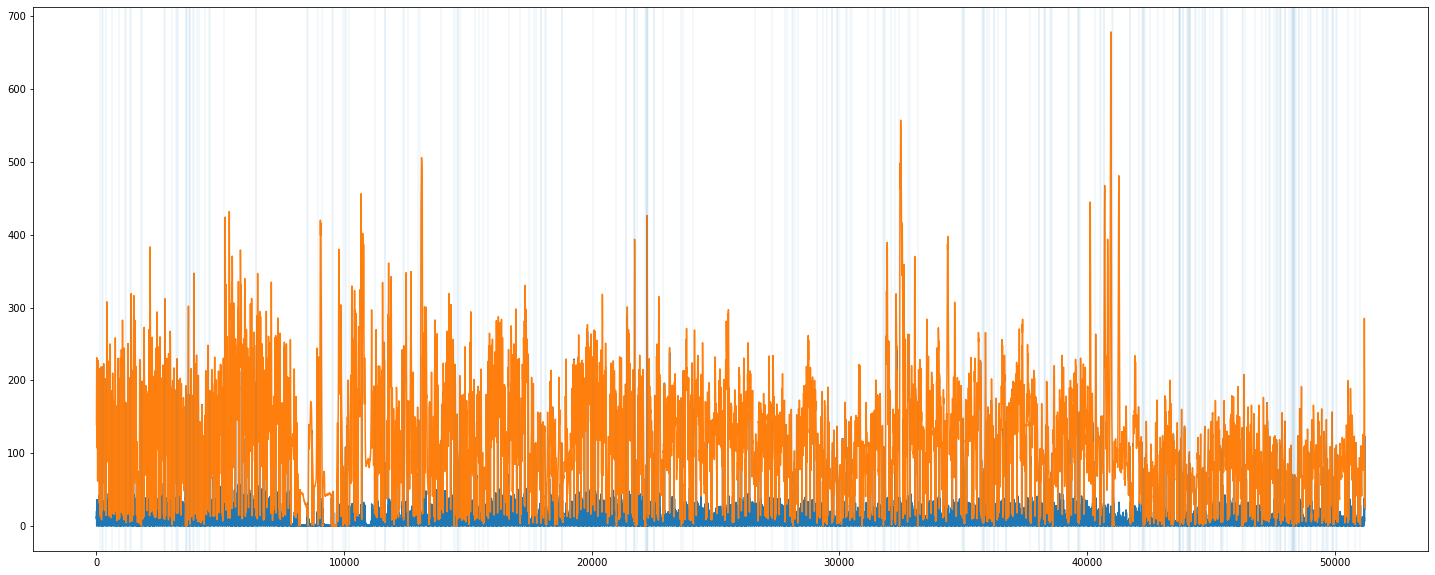

In [51]:
plt.figure(figsize=(25,10))
plt.plot(fishQuadDistance[:,1]+fishQuadDistance[:,0])
plt.plot(fishQuadDistance[:,2]+fishQuadDistance[:,3])
for i in range(len(nonOverlappingRange)-1):
    plt.axvline(x=nonOverlappingRange[i][1],linewidth=.1)
plt.show()

In [43]:
statusArray=[]
for i in range(len(fishQuadDistance)):
    if ((fishQuadDistance[i,1]+fishQuadDistance[i,0])==(fishQuadDistance[i,2]+fishQuadDistance[i,3]))==True:
        statusArray.append(2)
    elif ((fishQuadDistance[i,1]+fishQuadDistance[i,0])<(fishQuadDistance[i,2]+fishQuadDistance[i,3]))==True:
        statusArray.append(1)
    elif ((fishQuadDistance[i,1]+fishQuadDistance[i,0])>(fishQuadDistance[i,2]+fishQuadDistance[i,3]))==True:
        statusArray.append(0)
print(collections.Counter(statusArray))

Counter({1: 48631, 2: 1930, 0: 652})


# TODO
- rewrite the longest intervel checker for nonOverlappingRanges
- rewrite 2.6 using np.linalg.norm
    - can write output as pair of sums (use 1/2)
- write loop that outputs false where no swap, true where is swap, then another loop to finds changes in booleans.
    - use ints instead of booleans so can do 0=unswaped, 1=swapped, 2=overlapping
    - if all 4 same:2
    - if sum >1 and off>diag:1
    - else 0